<a href="https://colab.research.google.com/github/sanishrai/MNIST_Logistic_Regression/blob/logisticregression_update/2B_MultiLayer_Perceptron_Assignment_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Assignment: Multi-Layer Perceptron (MLP)

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Sanish Rai

### Multi-Layer Perceptrons

The simple logistic regression example we went over in the previous notebook is essentially a one-layer neural network, projecting straight from the input to the output predictions.
While this can be effective for linearly separable data, occasionally a little more complexity is necessary.
Neural networks with additional layers are typically able to learn more complex functions, leading to better performance.
These additional layers (called "hidden" layers) transform the input into one or more intermediate representations before making a final prediction.

In the logistic regression example, the way we performed the transformation was with a fully-connected layer, which consisted of a linear transform (matrix multiply plus a bias).
A neural network consisting of multiple successive fully-connected layers is commonly called a Multi-Layer Perceptron (MLP). 
In the simple MLP below, a 4-d input is projected to a 5-d hidden representation, which is then projected to a single output that is used to make the final prediction.

<img src="MLP.png" width="300"/>




For the assignment, you will be building a MLP for MNIST.
Mechanically, this is done very similary to our logistic regression example, but instead of going straight to a 10-d vector representing our output predictions, we might first transform to a 500-d vector with a "hidden" layer, then to the output of dimension 10.
Before you do so, however, there's one more important thing to consider.

### Nonlinearities

We typically include nonlinearities between layers of a neural network.
There's a number of reasons to do so.
For one, without anything nonlinear between them, successive linear transforms (fully connected layers) collapse into a single linear transform, which means the model isn't any more expressive than a single layer.
On the other hand, intermediate nonlinearities prevent this collapse, allowing neural networks to approximate more complex functions.

There are a number of nonlinearities commonly used in neural networks, but one of the most popular is the [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)):

\begin{align}
x = \max(0,x)
\end{align}

There are a number of ways to implement this in PyTorch.
We could do it with elementary PyTorch operations:

In [ ]:
import torch

x = torch.rand(5, 3)*2 - 1
x_relu_max = torch.max(torch.zeros_like(x),x)

print("x: {}".format(x))
print("x after ReLU with max: {}".format(x_relu_max))

x: tensor([[-0.8279, -0.3477,  0.7994],
        [ 0.1336, -0.9184,  0.4221],
        [-0.3805,  0.1873, -0.8515],
        [ 0.5280,  0.1000,  0.3768],
        [-0.1796,  0.0771, -0.5898]])
x after ReLU with max: tensor([[0.0000, 0.0000, 0.7994],
        [0.1336, 0.0000, 0.4221],
        [0.0000, 0.1873, 0.0000],
        [0.5280, 0.1000, 0.3768],
        [0.0000, 0.0771, 0.0000]])


Of course, PyTorch also has the ReLU implemented, for example in `torch.nn.functional`:

In [ ]:
import torch.nn.functional as F

x_relu_F = F.relu(x)

print("x after ReLU with nn.functional: {}".format(x_relu_F))

Same result.

### Assignment

Build a 2-layer MLP for MNIST digit classfication. Feel free to play around with the model architecture and see how the training time/performance changes, but to begin, try the following:

Image (784 dimensions) ->  
fully connected layer (500 hidden units) -> nonlinearity (ReLU) ->  
fully connected (10 hidden units) -> softmax

Try building the model both with basic PyTorch operations, and then again with more object-oriented higher-level APIs. 
You should get similar results!


*Some hints*:
- Even as we add additional layers, we still only require a single optimizer to learn the parameters.
Just make sure to pass all parameters to it!
- As you'll calculate in the Short Answer, this MLP model has many more parameters than the logisitic regression example, which makes it more challenging to learn.
To get the best performance, you may want to play with the learning rate and increase the number of training epochs.
- Be careful using `torch.nn.CrossEntropyLoss()`. 
If you look at the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#crossentropyloss): you'll see that `torch.nn.CrossEntropyLoss()` combines the softmax operation with the cross-entropy.
This means you need to pass in the logits (predictions pre-softmax) to this loss.
Computing the softmax separately and feeding the result into `torch.nn.CrossEntropyLoss()` will significantly degrade your model's performance!

In [5]:
### YOUR CODE HERE
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm




# class MNIST_ML(nn.Module):
#   def __init__(self, x_size, label_size):
#     super().__init__()
#     self.lin = nn.Linear(x_size,label_size)

#   def forward(self,x):
#     return self.lin(x)

class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out)/np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
        
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)


#Parameters for the input layer and hidden layer
lin_par1 = xW_plus_b(784, 500)
# print("W: {}".format(lin_custom_w1.W.shape))
# print("b: {}".format(lin_custom_w1.b.shape))

#Parameters for the hidden layer and output layer
lin_par2 = xW_plus_b(500, 10)

# Optimizer for output layer
optimizer = torch.optim.SGD([lin_par2.W,lin_par2.b], lr=0.1)



# Make sure to print out your accuracy on the test set at the end.

In [38]:
#use gpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [20]:
# Iterate through train set minibatchs 
epoch = 10
for i in range(epoch):
  for images, labels in tqdm(train_loader):
      # Zero out the gradients
      optimizer.zero_grad()
      
      # Forward pass between output and hidden layer
      x = images.view(-1, 28*28) #image size is 28 by 28
      y_1 = lin_par1.forward(x) #output of the first layer

      #relu
      y_1_relu = torch.max(torch.zeros_like(y_1),y_1)

      # Forward pass between output and hidden layer
      #x is y_1
      y = lin_par2.forward(y_1_relu)
      #cross entropy and softmax using pytorch NN cross_entropy
      # Note that PyTorch's cross-entropy loss combines the softmax operator and cross-entropy into a single operation, for numerical stability reasons. 
      # Don't do the softmax twice! Make sure to feed in the pre-softmax logits y, not the post-softmax probabilities py.
      cross_entropy = F.cross_entropy(y, labels)
      # Backward pass
      cross_entropy.backward()
      optimizer.step()

In [21]:
##Testing
correct = 0
total = len(mnist_test)
with torch.no_grad():
  #iterate through test set
  for images, labels in tqdm(test_loader):
    # Forward pass between output and hidden layer
    x = images.view(-1, 28*28) #image size is 28 by 28
    y_1 = lin_par1.forward(x) #output of the first layer
    #cross entropy and softmax using pytorch NN cross_entropy

    y_1_relu = torch.max(torch.zeros_like(y_1),y_1)

    # Forward pass between output and hidden layer
    #x is y_1
    y = lin_par2.forward(y_1_relu)
    #now y is the prediction
    predictions  = torch.argmax(y,dim=1)
    correct += torch.sum((predictions == labels).float())

print('Test accuracy: ', correct/total)


Test accuracy:  tensor(0.9215)


torch.Size([784, 500])
torch.Size([500, 10])


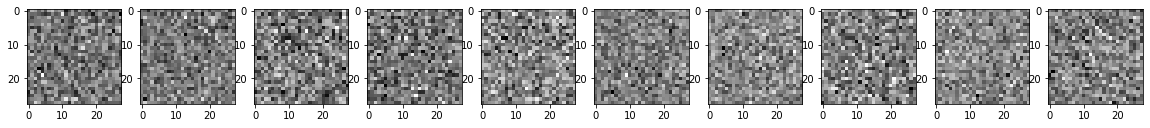

In [36]:
#check the template
%matplotlib inline
import matplotlib.pyplot as plt
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(lin_par1.W[:,digit].detach().view(28,28), cmap='gray')

print(lin_par1.W.shape)
print(lin_par2.W.shape)



### Short answer
How many trainable parameters does your model have? 
How does this compare to the logisitic regression example?

`[Your answer here]`